# Tutorial 5: BH mass

## 1. Estimate MBH using scaling relations derived from reverberation mapping studies + estimation of accretion rate.

This part of the assignment is designed as a guide for estimating black hole mass using scaling relations derived from reverberation mapping studies.

You are given a sample of 500 quasars with a selection of measured spectral parameters from Shen et al. (2011), including SDSS spectral identification numbers
(mjd, plate, fiber) and full width at half maximum of Hβ line^1. Other parameters, like
Hβ line luminosity, bolometric luminosity, black hole masses, and Eddington ratio
are provided as a reference for comparison to the values you calculate yourself. See
Shen et al. (2011) catalog for detailed description of these and other parameters.
For the purpose of this exercise, you are allowed to use only FWHM Hβ for your
calculations.

1^Optionally, you are invited to test for a selected object from the given sample, what
would you get for the Hβ FWHM with your own spectral analysis with FANTASY.

#### a) To begin, cross-match provided catalog with SDSS to obtain Hβ flux and redshift.

#### Do some exploratory data analysis of the sample: plot redshift and FWHM distribution of the sample, plot i-band magnitude vs. redshift, and describe sample limitations in terms of these plots and parameters (hint: pandas is useful for this).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.integrate import quad
%matplotlib inline

from astroquery.simbad import Simbad

In [2]:
df = pd.read_csv("shen_subsample_500.csv")
df.head()

,RAJ2000,DEJ2000,Plate,Fiber,MJD,iMAG,logLbol,e_logLbol,logLBHb,e_logLBHb,W_BHb_,e_W_BHb_,EWBHb,e_EWBHb,SN_Hb_,logBH,e_logBH,logEdd
0,189.67804,45.30687,1372,486,53062,-23.20,45.236,0.004,42.35,0.02,4399.3,330.1,62.0,3.1,23.06,8.33,0.07,-1.20
1,189.77188,41.44564,1984,609,53433,-22.29,44.819,0.005,42.11,0.04,2371.4,541.6,89.4,8.7,15.06,7.59,0.20,-0.87
2,189.81419,53.23740,885,449,52379,-22.69,45.121,0.004,41.93,0.04,10756.6,4366.4,32.1,3.4,16.27,9.05,0.35,-2.03
3,189.93733,19.90707,2614,350,54481,-23.37,45.132,0.001,42.55,0.02,15241.3,362.8,118.7,6.3,19.79,9.36,0.02,-2.33
4,189.99405,49.09448,1278,96,52735,-22.77,45.166,0.011,42.25,0.01,1385.6,48.6,52.5,2.9,15.96,7.29,0.03,-0.23


In [3]:
data = pd.read_csv("CrossID_op.csv")
data = data.merge(df[['Plate', 'MJD', 'Fiber','W_BHb_','e_W_BHb_','iMAG']], how='inner', on=['Plate', 'MJD', 'Fiber'])
data.head()

,specobjid,ra,dec,Plate,MJD,Fiber,z,h_beta_flux,W_BHb_,e_W_BHb_,iMAG
0,1173224032531671040,204.87080,52.456516,1042,52725,132,0.269020,621.0911,3787.5,1183.1,-23.30
1,1177738073073543168,217.66379,49.594165,1046,52460,170,0.203462,711.2766,2467.0,65.4,-23.02
2,1178914829973350400,218.79294,49.805383,1047,52733,355,0.166059,237.4101,7380.1,1126.2,-22.65
3,1642709456854738944,197.36168,45.715832,1459,53117,78,0.268205,134.0795,11318.1,3037.8,-23.36
4,1912994979127519232,201.73091,12.782964,1699,53148,331,0.201720,287.0493,4224.0,525.2,-22.46


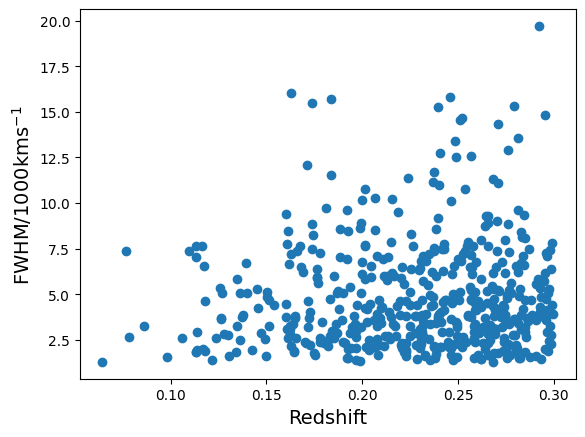

In [4]:
# plot redshift and FWHM distribution of the sample
plt.plot(data['z'],data['W_BHb_']/1000,'o')
plt.ylabel('FWHM/1000kms$^{-1}$', fontsize=14)
plt.xlabel('Redshift', fontsize=14);

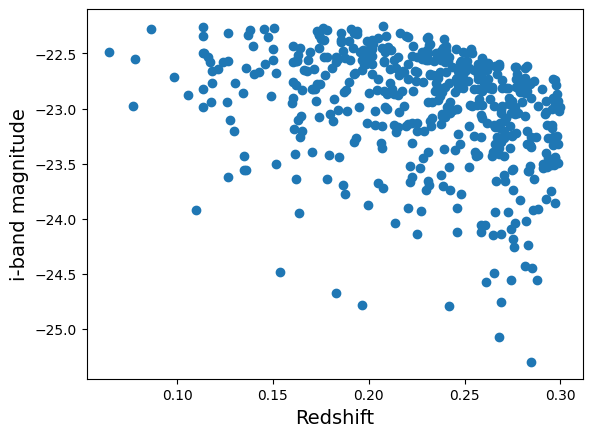

In [5]:
# plot i-band magnitude vs. redshift
plt.plot(data['z'],data['iMAG'],'o')
plt.ylabel('i-band magnitude', fontsize=14)
plt.xlabel('Redshift', fontsize=14);

#### b) Next, using the provided FWHM and SDSS data, find:

- #### The luminosity of the Hβ emission line. For this, you will need to calculate the luminosity distance for each object using formulas given by Hogg (2000). For cosmological constants, use ones from Planck (H0=67.8 km/s MPc, Ωm=0.31, Ωλ=0.69). Using luminosity distance, Hβ flux and redshift, find the luminosity of the Hβ emission line.

In [6]:
c = 3e8 # m/s
H0 = 67.8e3 # m/s /Mpc
D_H = c/H0 * 3.086e+22 # m
omg_m = 0.31
omg_l = 0.69
omg_k = 1- omg_m - omg_l

def E(z):
    return np.sqrt(omg_m*(1+z)**3 + omg_k*(1+z)**2 + omg_l)

data['D_C'] = np.nan
D_C = np.zeros(len(data.z))

for i in range(len(data)):
    data['D_C'][i] = D_H*quad(lambda z1: 1/E(z1), 0, data['z'][i])[0]

data['D_M'] = data['D_C'] # since omg_k = 0
data['D_L'] = (1+data.z)*data['D_M']

data = data.drop(columns=['D_M', 'D_C'])

/tmp/ipykernel_33462/1840207923.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['D_C'][i] = D_H*quad(lambda z1: 1/E(z1), 0, data['z'][i])[0]
/tmp/ipykernel_33462/1840207923.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['D_C'][i] = D_H*quad(lambda z1: 1/E(z1), 0, data['z'][i])[0]
/tmp/ipykernel_33462/1840207923.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['D_C'][i] = D_H*quad(lambda z1: 1/E(z1), 0, dat

In [7]:
# according to the schema browser, the units of H_beta flux is 1e-17 erg/s/cm^2

LHb = (data.h_beta_flux*1e-17*1e4)*4*np.pi*data.D_L**2
data['logLHb'] = np.log10(LHb)

- ####  Using the empirical relation from Section 3 in Wu (2009), calculate black hole mass using the luminosity of the Hβ line and FWHM Hβ. You should elaborate on the assumption you have to make to use this relation.

In [8]:
# black hole mass using the luminosity of the Hβ line and FWHM Hβ 
# Mass of the sun = 1.989e30 kg
MBH_Ms = 2.4e6*(LHb*1e-42)**0.59 * (data.W_BHb_*1e-3)**2
data['logBH'] = np.log10(MBH_Ms)

- #### Estimate the Eddington luminosity and Eddington ratio after having derived the bolometric luminosity (e.g., use empirical relations from Wu 2009).

In [9]:
# bolometric luminosity calculation
data['logLbol'] = (0.94+0.03)*data['logLHb']+(5.39-1.14)

In [10]:
# eddington luminosity calculation
LEdd = 1.38e38*MBH_Ms
data['logL_Edd'] = np.log10(LEdd)

In [11]:
# eddington ratio
data['logEdd'] = data['logLbol']-data['logL_Edd'] #log10(Lbol/LEdd)

In [12]:
data.head()

,specobjid,ra,dec,Plate,MJD,Fiber,z,h_beta_flux,W_BHb_,e_W_BHb_,iMAG,D_L,logLHb,logBH,logLbol,logL_Edd,logEdd
0,1173224032531671040,204.87080,52.456516,1042,52725,132,0.269020,621.0911,3787.5,1183.1,-23.30,4.359588e+25,42.171256,7.637958,45.156118,45.777837,-0.621718
1,1177738073073543168,217.66379,49.594165,1046,52460,170,0.203462,711.2766,2467.0,65.4,-23.02,3.180538e+25,41.956249,7.138737,44.947562,45.278616,-0.331054
2,1178914829973350400,218.79294,49.805383,1047,52733,355,0.166059,237.4101,7380.1,1126.2,-22.65,2.539282e+25,41.284131,7.693973,44.295607,45.833852,-1.538245
3,1642709456854738944,197.36168,45.715832,1459,53117,78,0.268205,134.0795,11318.1,3037.8,-23.36,4.344517e+25,41.502455,8.194207,44.507382,46.334086,-1.826704
4,1912994979127519232,201.73091,12.782964,1699,53148,331,0.201720,287.0493,4224.0,525.2,-22.46,3.150147e+25,41.553828,7.368418,44.557213,45.508297,-0.951083


#### c) How would you describe these AGNs based on the properties you found?
#### Provide histograms of obtained black hole masses and Eddington ratios. Present your results as in Figure 2 from Wu (2009), and Figure 7 from McLure & Dunlop (2002), or on any plots that you find appropriate to illustrate your conclusions. 

#### Optionally, you can compare your values to values from Shen et al. (2011).

In [13]:
data.describe()

,specobjid,ra,dec,Plate,MJD,Fiber,z,h_beta_flux,W_BHb_,e_W_BHb_,iMAG,D_L,logLHb,logBH,logLbol,logL_Edd,logEdd
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000
mean,1.750423e+18,209.899608,28.282935,1554.610000,53234.560000,319.980000,0.226942,547.729377,4825.009600,580.251600,-22.98284,3.614965e+25,41.679023,7.413243,44.678652,45.553122,-0.874470
std,8.023724e+17,11.374865,19.338788,712.648956,842.752803,188.688533,0.049635,737.155402,2975.763737,788.782701,0.52241,8.711173e+24,0.404144,0.392895,0.392019,0.392895,0.607697
min,3.310679e+17,189.678030,-3.513874,294.000000,51613.000000,1.000000,0.064495,14.087560,1281.100000,24.700000,-25.30000,9.232372e+24,40.448663,6.398757,43.485204,44.538636,-2.517400
25%,1.080640e+18,200.252020,10.479356,959.750000,52439.000000,157.500000,0.193991,153.956825,2621.675000,202.450000,-23.25000,3.015937e+25,41.415280,7.133704,44.422822,45.273583,-1.340236
50%,1.882640e+18,209.316860,27.995375,1672.000000,53147.500000,301.000000,0.236845,286.204300,3997.300000,330.800000,-22.84000,3.772399e+25,41.684107,7.432216,44.683584,45.572095,-0.849579
75%,2.289063e+18,219.596010,43.827155,2033.000000,53884.000000,490.250000,0.267921,590.527200,6338.725000,625.675000,-22.60000,4.339264e+25,41.956947,7.685082,44.948239,45.824961,-0.392308
max,3.324848e+18,231.141930,67.824763,2953.000000,54562.000000,640.000000,0.299768,6220.282000,19717.100000,7686.400000,-22.25000,4.935448e+25,42.935655,8.646620,45.897585,46.786499,0.372703


These AGNs are very luminous and contain very massive black holes.

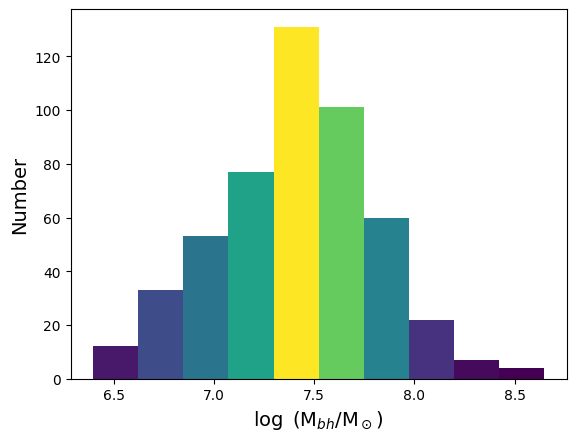

In [14]:
# The histogram distribution of the black hole masses
from matplotlib import colors

N, bins, patches = plt.hist(data['logBH'])
plt.xlabel('$\log$ (M$_{bh}/$M$_\odot)$ ', fontsize=14)
plt.ylabel('Number', fontsize=14)

# Color coding by height to make a pretty plot
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

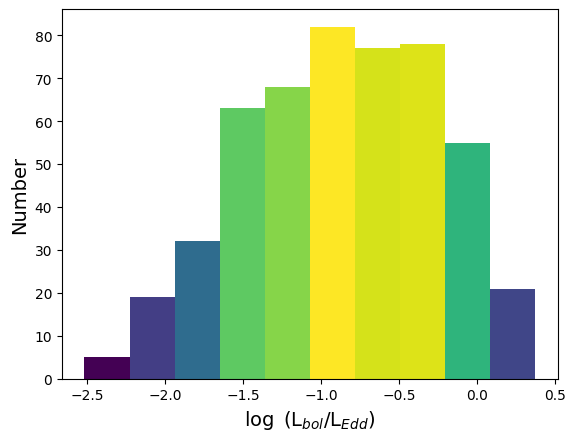

In [15]:
# The histogram distribution of the Eddington ratios

N, bins, patches = plt.hist(data['logEdd'])
plt.xlabel(r'$\log$ (L$_{bol}/$L$_{Edd})$', fontsize=14)
plt.ylabel('Number', fontsize=14)

# Color coding by height to make a pretty plot
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

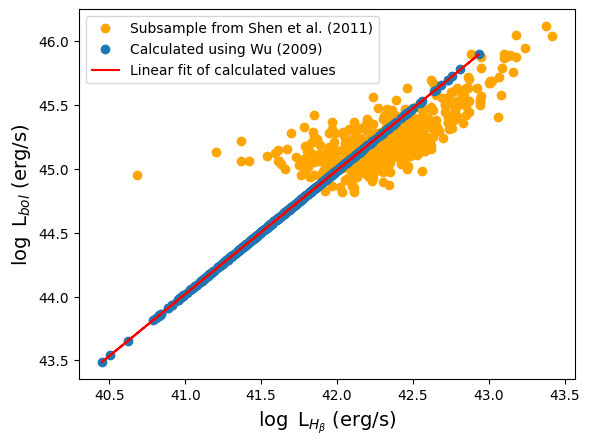

In [27]:
# Fig 2 from Wu (2009)

plt.plot(df.logLBHb, df.logLbol,'o', label='Subsample from Shen et al. (2011)', c='orange')
plt.plot(data.logLHb, data.logLbol,'o', label='Calculated using Wu (2009)')

#line fitting
m, b = np.polyfit(data.logLHb, data.logLbol, 1)
y_fit = m*data.logLHb+b
plt.plot(data.logLHb, y_fit, c='r', label='Linear fit of calculated values')

plt.ylabel('$\log$ L$_{bol}$ (erg/s)', fontsize=14)
plt.xlabel(r'$\log$ L$_{H_\beta}$ (erg/s)', fontsize=14)
plt.legend();

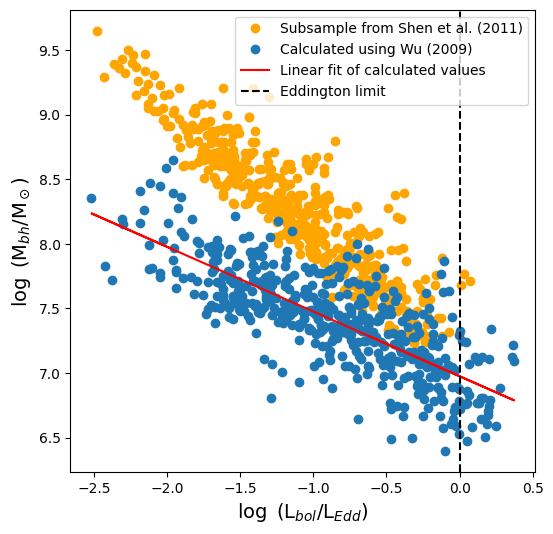

In [26]:
# Fig 7 from McLure & Dunlop (2002)

plt.figure(figsize=(6,6))

plt.plot(df.logEdd, df.logBH,'o', label='Subsample from Shen et al. (2011)', c='orange')
plt.plot(data.logEdd, data.logBH,'o', label='Calculated using Wu (2009)')

# line fitting
m, b = np.polyfit(data.logEdd, data.logBH, 1)
y_fit = m*data.logEdd+b
plt.plot(data.logEdd, y_fit, c='r', label='Linear fit of calculated values')

# to show eddington limit
plt.axvline(0,linestyle='dashed', c='black', label='Eddington limit') 

plt.ylabel('$\log$ (M$_{bh}/$M$_\odot)$ ', fontsize=14)
plt.xlabel(r'$\log$ (L$_{bol}/$L$_{Edd})$', fontsize=14)

plt.legend()
plt.show()

## 2. Estimate MBH from galactic host bulge luminosity + estimation of accretion rate.

In this part of the assignment you will learn how to estimate black hole mass from galactic host bulge luminosity. It is useful in cases when you don’t have spectroscopic data for broad emission lines.

#### Calculate black hole mass for at least 10 objects from Wu (2009) using the relation between black hole mass and host galaxy absolute magnitude in the R band given in Wu (2009) and proposed by McLure & Dunlop (2002). 
Elaborate on the
assumptions you have to make in order to use this relation. You will need to obtain
magnitudes in Johnson- Cousins photometric system (e.g., you can try searching
the NED database). Additionally, find the Eddington ratio and plot it against obtained
black hole masses. Optionally, you can plot your black hole mass and Eddington
ratio estimates against ones from Wu et al. (2009) and discuss what you find.


The following ADQL query was used in Simbad TAP Service to obtain data from Wu(2009):

This chooses 26 objects from the paper, which we will use to calculate the BH mass using R band magnitude:

In [18]:
wu = pd.read_csv('simbad.txt', sep='|')
wu.head()

,oid,main_id,rvz_redshift,otype,ra,dec,U,B,V,R
0,5036418,LEDA 139813,0.026598,Sy2,185.930703,-42.592231,19.45,17.28,17.75,15.69
1,1000586,3C 186,1.065510,QSO,116.072800,37.888125,,17.50,18.14,17.20
2,285414,ICRF J182931.7+484446,0.691663,Sy1,277.382421,48.746156,,17.05,16.81,16.86
3,1380415,QSO B2134+0028,1.941250,QSO,324.160776,0.698392,,17.30,17.08,17.02
4,2506951,2MASX J20210438-2235183,0.185000,Sy1,305.266933,-22.590493,,17.53,16.80,16.28


The two main asumptions used in this paper are:

- disc-like broad-line regions
- purely random broad-line velocities

In [19]:
# calculating luminosity distances
wu['D_C'] = np.nan

for i in range(len(wu)):
    wu['D_C'][i] = D_H*quad(lambda z1: 1/E(z1), 0, wu['rvz_redshift'][i])[0]

wu['D_M'] = wu['D_C'] # since omg_k = 0
wu['D_L'] = (1+wu.rvz_redshift)*wu['D_M']

wu = wu.drop(columns=['D_M', 'D_C'])

/tmp/ipykernel_33462/939626378.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wu['D_C'][i] = D_H*quad(lambda z1: 1/E(z1), 0, wu['rvz_redshift'][i])[0]
/tmp/ipykernel_33462/939626378.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wu['D_C'][i] = D_H*quad(lambda z1: 1/E(z1), 0, wu['rvz_redshift'][i])[0]
/tmp/ipykernel_33462/939626378.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wu['D_C'][i] = D_H*quad(lambda z1: 1/E(z1), 

In [20]:
# converting apparent to absolute magnitude
wu['M_R'] = wu['R'] - 5*np.log10(wu['D_L']*3.24078e-17/10)
wu['M_V'] = wu['V'] - 5*np.log10(wu['D_L']*3.24078e-17/10)

In [21]:
# black hole mass and host galaxy absolute magnitude in the R band 
# given in Wu (2009) and proposed by McLure & Dunlop (2002)
wu['logBH'] = -0.5*wu['M_R'] - 2.74 

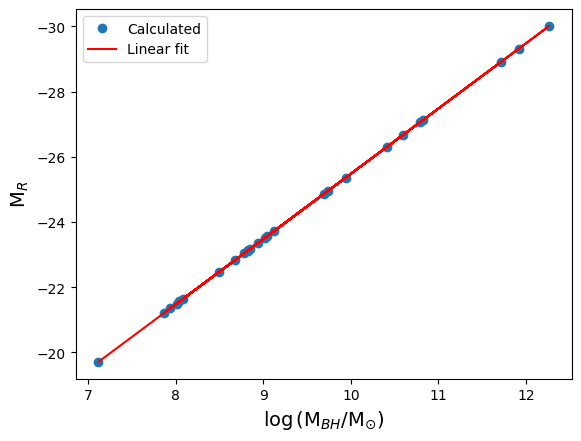

In [22]:
# Fig 4 from McLure & Dunlop (2002)

plt.plot(wu['logBH'],wu['M_R'],'o', label='Calculated')

# line fitting
m, b = np.polyfit(wu['M_R'],wu['logBH'], 1)
BH_fit = m*wu['M_R']+b
plt.plot(BH_fit,wu['M_R'],c='r', label='Linear fit')

plt.gca().invert_yaxis()
plt.xlabel(r'$\log$(M$_{BH}/$M$_{\odot})$', fontsize=14)
plt.ylabel(r'M$_R$', fontsize=14)
plt.legend();

In [23]:
# eddington luminosity
LEdd = 1.38e38*10**wu['logBH']
wu['logL_Edd'] = np.log10(LEdd)

# converting V_mag to L_opt 
wu['logLopt'] = (71.197425 - wu['M_V'])/2.5

# using approximation L_bol ~ 10L_opt from WU (2009)
wu['logLbol'] = np.log10(10*(10**wu['logLopt']))

# eddington ratio
wu['logEdd']= wu['logLbol'] - wu['logL_Edd']

In [24]:
wu.head()

,oid,main_id,rvz_redshift,otype,ra,dec,U,B,V,R,D_L,M_R,M_V,logBH,logL_Edd,logLopt,logLbol,logEdd
0,5036418,LEDA 139813,0.026598,Sy2,185.930703,-42.592231,19.45,17.28,17.75,15.69,3.705404e+24,-19.707425,-17.647425,7.113713,45.253592,35.537940,36.537940,-8.715652
1,1000586,3C 186,1.065510,QSO,116.072800,37.888125,,17.50,18.14,17.20,2.264806e+26,-27.128403,-26.188403,10.824202,48.964081,38.954331,39.954331,-9.009749
2,285414,ICRF J182931.7+484446,0.691663,Sy1,277.382421,48.746156,,17.05,16.81,16.86,1.332367e+26,-26.316368,-26.366368,10.418184,48.558063,39.025517,40.025517,-8.532546
3,1380415,QSO B2134+0028,1.941250,QSO,324.160776,0.698392,,17.30,17.08,17.02,4.737036e+26,-28.910781,-28.850781,11.715391,49.855270,40.019282,41.019282,-8.835987
4,2506951,2MASX J20210438-2235183,0.185000,Sy1,305.266933,-22.590493,,17.53,16.80,16.28,2.861055e+25,-23.555879,-23.035879,9.037939,47.177818,37.693322,38.693322,-8.484497


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


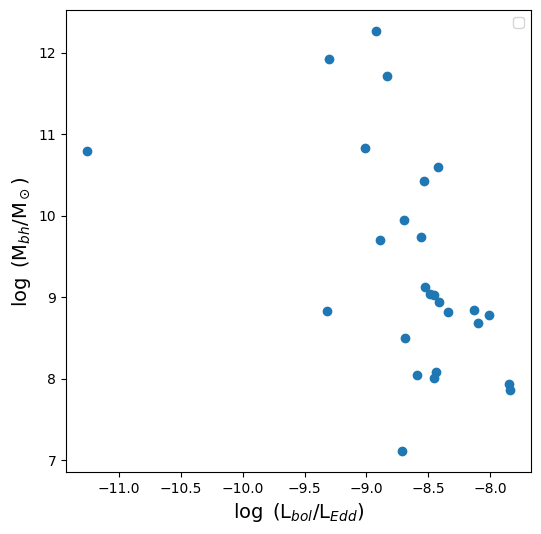

In [25]:
# Fig 7 from McLure & Dunlop (2002)

plt.figure(figsize=(6,6))

plt.plot(wu.logEdd, wu.logBH,'o')#, label='Calculated from Wu (2009)')

# line fitting
# m, b = np.polyfit(wu.logEdd, wu.logBH, 1)
# y_fit = m*wu.logEdd+b
# plt.plot(wu.logEdd, y_fit, c='r', label='Linear fit of calculated values')

# to show eddington limit
# plt.axvline(0,linestyle='dashed', c='black', label='Eddington limit') 

plt.ylabel('$\log$ (M$_{bh}/$M$_\odot)$ ', fontsize=14)
plt.xlabel(r'$\log$ (L$_{bol}/$L$_{Edd})$', fontsize=14)

plt.legend()
plt.show()